In [37]:
import numpy as np
import pandas as pd
import pm4py
import numpy as np
from pm4py.objects.conversion.log import converter as log_converter
from scipy.stats import variation
from scipy import stats
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.statistics.eventually_follows.log import get as efg_get
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sklearn.preprocessing as sk
from scipy.stats import chi2_contingency
import math
import statistics
import graphviz
from statsmodels.stats import multitest
from statsmodels.stats.contingency_tables import SquareTable as ST
import sys
import sklearn
import scipy
from scipy.stats import shapiro
import os
import sys
%load_ext autoreload
%autoreload 2
import pandas as pd
import json
import pm4py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
pd.set_option("display.max_rows", 800)

In [40]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from package.process_change_analyzer import ProcessChangeAnalyzer

In [41]:
%matplotlib inline

In [42]:
# Load inital event log + clean from unnecessary columns

dataset = pd.read_csv("Logs/Kidney_Failure_Log.csv")
#dataset.rename(columns={"intime":"time:timestamp"}, inplace=True)
columns_to_drop = ['Unnamed: 0', 'subject_id'] #,'intime','outtime']
final_pm = dataset.drop(columns_to_drop, axis=1)
#specify activity column
activity = "department"
#specify case id
case_id = "hadm_id"

In [43]:
def classify_attributes(proc_c):
    for index, row in proc_c.iterrows():
        if((row["numberOfActivities"] == 1) & (row["numberOfTraceOccurence (Mean)"] == 1)):
            proc_c.at[index, "class"] = "static"
        elif((row["numberOfActivities"] > 1) & (row["numberOfTraceOccurence (Mean)"] == 1)):
            proc_c.at[index, "class"] = "semi-dynamic"
        else:
            proc_c.at[index, "class"] = "dynamic"
    return proc_c

In [44]:
#Classify event attributes, so that dynamic event attributes can be identified

activities = final_pm[activity].unique()

matrix = pd.DataFrame(data=None, columns=activities)

#identify attributes for activities
att_card = pd.DataFrame(data=None,columns=final_pm.columns)
for dep in activities:
    dep_data = final_pm.loc[final_pm[activity] == dep]
    y = dep_data.groupby(activity).agg({lambda x: x.notnull().sum()})
    y.columns = y.columns.droplevel(1)
    y = y.reset_index().drop(activity, axis=1)
    row_num = len(dep_data)
    row = y.loc[0]
    for col in y.columns:
        t = 0.05
        if(row[col] > (row_num*t)):
            row[col] = 1
        else:
            row[col] = 0
    row[activity] = dep
    att_card = att_card.append(row)
    


att_card.drop(case_id, axis=1, inplace=True)

# for each attribute: number of activities + number of occurence in a trace

number_trace_occurence = final_pm.groupby(case_id).agg({lambda x: x.notnull().sum()})

#drop concept:name
number_trace_occurence.drop(activity, axis=1, inplace=True)

number_trace_occurence.columns = number_trace_occurence.columns.droplevel(1)

number_trace_occurence = number_trace_occurence.replace(0, np.NaN)

number_trace_occurence = number_trace_occurence.mean()

number_trace_occurence = number_trace_occurence.rename("numberOfTraceOccurence (Mean)")

number_of_activities = pd.Series([], name="numberOfActivities")

for col in final_pm.columns:
    if((col != case_id) & (col != activity)):
        number_of_activities[col] = len(final_pm[[activity, col]].dropna()[activity].unique())

process_characteristics = pd.concat([number_of_activities, number_trace_occurence], axis=1)

for col in final_pm.columns:
    if (final_pm[col].nunique()/final_pm[col].count() < 0.05):
        process_characteristics.loc[col, "type"] = "categorical"
    else:
        process_characteristics.loc[col, "type"] = "continuous"

process_characteristics = process_characteristics.drop(labels=[case_id, activity])

x = process_characteristics

x = classify_attributes(process_characteristics)

x = x.reset_index()

x = x.rename({"index":"Activity"}, axis=1)

attribute_classes = x[["Activity", "class", "type"]]

attribute_classes["CV"] = 0

deps = ["Emergency Department", "Pre-ICU Medicine", "Pre-ICU Cardiology", "Cardiac ICU", "Medical ICU", "Surgical ICU", "Post-ICU Cardiology", "Post-ICU Medicine", "Post-ICU Surgery", "Discharged"]

attribute_list_con = list(attribute_classes.loc[(attribute_classes["class"] == "dynamic") & (attribute_classes["type"] == "continuous")]["Activity"])

attribute_list_cat = list(attribute_classes.loc[(attribute_classes["class"] == "dynamic") & (attribute_classes["type"] == "categorical")]["Activity"])

In [48]:
attribute_list_cat

['Abnormal Glucose',
 'Abnormal Potassium',
 'Abnormal Sodium',
 'Abnormal Chloride',
 'Abnormal Bicarbonate',
 'Abnormal Creatinine',
 'Abnormal Anion Gap',
 'Abnormal Urea Nitrogen',
 'Abnormal Magnesium',
 'Abnormal Phosphate',
 'Abnormal Calcium',
 'Abnormal Hematocrit',
 'Abnormal Hemoglobin',
 'Abnormal Platelet Count',
 'Abnormal White Blood Cells',
 'Abnormal MCHC',
 'Abnormal RDW',
 'Abnormal MCH',
 'Abnormal Red Blood Cells',
 'Abnormal MCV',
 'Abnormal pH',
 'Abnormal PTT',
 'Abnormal INR(PT)',
 'Abnormal PT',
 'Abnormal pO2',
 'Abnormal Calculated Total CO2',
 'Abnormal pCO2',
 'Abnormal RDW-SD']

In [15]:
# manually set inputs for the package

#specify activity and case id column
activity = "department"
case_id = "hadm_id"
time_column = "intime"
attribute_list_con = attribute_list_con[3:]
attribute_list_con.append("time:timestamp")
# type of variables to use
continuous_columns = attribute_list_con.copy()

categorical_columns = attribute_list_cat.copy()

In [53]:
len(continuous_columns)

29

In [54]:
len(categorical_columns)

28

In [55]:
categorical_columns

['Abnormal Glucose',
 'Abnormal Potassium',
 'Abnormal Sodium',
 'Abnormal Chloride',
 'Abnormal Bicarbonate',
 'Abnormal Creatinine',
 'Abnormal Anion Gap',
 'Abnormal Urea Nitrogen',
 'Abnormal Magnesium',
 'Abnormal Phosphate',
 'Abnormal Calcium',
 'Abnormal Hematocrit',
 'Abnormal Hemoglobin',
 'Abnormal Platelet Count',
 'Abnormal White Blood Cells',
 'Abnormal MCHC',
 'Abnormal RDW',
 'Abnormal MCH',
 'Abnormal Red Blood Cells',
 'Abnormal MCV',
 'Abnormal pH',
 'Abnormal PTT',
 'Abnormal INR(PT)',
 'Abnormal PT',
 'Abnormal pO2',
 'Abnormal Calculated Total CO2',
 'Abnormal pCO2',
 'Abnormal RDW-SD']

In [16]:
analyzer = ProcessChangeAnalyzer(final_pm, activity, case_id, time_column, continuous_columns, categorical_columns)

In [17]:
analyzer.prepare_correlation()

In [18]:
analyzer.con_cat

hadm_id  \
department_prev      department                                                               
Cardiac ICU          Discharged           [20022423.0, 20139992.0, 20174883.0, 20204398....   
                     Post-ICU Cardiology  [20002636.0, 20009197.0, 20009241.0, 20017191....   
                     Post-ICU Medicine    [20004775.0, 20020317.0, 20072904.0, 20088865....   
                     Post-ICU Surgery     [20042202.0, 20215586.0, 20741363.0, 20947621....   
Emergency Department Cardiac ICU          [20004775.0, 20009241.0, 20017191.0, 20020317....   
                     Medical ICU          [20029639.0, 20043724.0, 20053986.0, 20058274....   
                     Pre-ICU Cardiology   [20002636.0, 20009197.0, 20250332.0, 20399252....   
                     Pre-ICU Medicine     [20035470.0, 20124229.0, 20139992.0, 20140574....   
                     Pre-ICU Surgery      [20053021.0, 20066510.0, 20072904.0, 20145585....   
                     Surgical ICU         [20008580.0, 20011640.0, 20015496.0, 20023063....   
Medical ICU          Discharged           [20060174.0, 20086226.0, 20088508.0, 20108756....   
                     Post-ICU Cardiology  [20043724.0, 20272369.0, 20356048.0, 20360941....   
                     Post-ICU Medicine    [20053986.0, 20058274.0, 20059021.0, 20063165....   
                     Post-ICU Surgery     [20029639.0, 20145585.0, 20157959.0, 20215264....   
Post-ICU Cardiology  Discharged           [20002636.0, 20009197.0, 20009241.0, 20017191....   
                     Post-ICU Medicine    [20096259.0, 20096259.0, 20399252.0, 21213879....   
                     Post-ICU Surgery                              [21737428.0, 27710348.0]   
Post-ICU Medicine    Discharged           [20004775.0, 20008580.0, 20011640.0, 20015496....   
                     Post-ICU Cardiology  [20096259.0, 23504833.0, 25229603.0, 25835454....   
                     Post-ICU Surgery      [23201707.0, 25770472.0, 28075599.0, 28188004.0]   
Post-ICU Surgery     Discharged           [20029639.0, 20042202.0, 20053021.0, 20101799....   
                     Post-ICU Cardiology  [20741363.0, 22774707.0, 27307767.0, 28946354....   
                     Post-ICU Medicine    [20730479.0, 21113017.0, 23881692.0, 24309759....   
Pre-ICU Cardiology   Cardiac ICU          [20002636.0, 20009197.0, 20250332.0, 20399252....   
                     Medical ICU          [21752523.0, 22355109.0, 23937111.0, 25005083....   
                     Pre-ICU Medicine                                          [22726537.0]   
                     Surgical ICU         [20379827.0, 21703018.0, 22956986.0, 23393787....   
Pre-ICU Medicine     Cardiac ICU          [20035470.0, 20124229.0, 20139992.0, 20248637....   
                     Medical ICU          [20204877.0, 20206823.0, 20437208.0, 20459901....   
                     Pre-ICU Cardiology   [20379827.0, 20750393.0, 21273831.0, 21960120....   
                     Pre-ICU Surgery                               [24795621.0, 28782684.0]   
                     Surgical ICU         [20140574.0, 20392650.0, 20396229.0, 20405881....   
Pre-ICU Surgery      Cardiac ICU          [20072904.0, 20416956.0, 21018237.0, 21030045....   
                     Medical ICU          [20066510.0, 20145585.0, 20453514.0, 20752001....   
                     Pre-ICU Cardiology                                        [26341594.0]   
                     Pre-ICU Medicine                              [23256980.0, 24795621.0]   
                     Surgical ICU         [20053021.0, 20362209.0, 20520808.0, 21672423....   
Surgical ICU         Discharged           [20023063.0, 20094915.0, 20137177.0, 20204673....   
                     Post-ICU Cardiology  [20449515.0, 21303564.0, 21388055.0, 21703018....   
                     Post-ICU Medicine    [20008580.0, 20011640.0, 20015496.0, 20053996....   
                     Post-ICU Surgery     [20053021.0, 20101799.0, 20121390.0, 20166763....   

In [19]:
analyzer.distribution_checker().sort_values('stat')

,previous_activity,activity,measure,stat,p,is_normal_distributed
754,Post-ICU Medicine,Post-ICU Surgery,Glucose,0.821186,0.145963,True
347,Pre-ICU Cardiology,Medical ICU,sum_timestamp,0.838455,0.015539,False
869,Pre-ICU Medicine,Pre-ICU Cardiology,sum_timestamp,0.864751,0.011769,False
763,Post-ICU Medicine,Post-ICU Surgery,Phosphate,0.879243,0.335411,True
756,Post-ICU Medicine,Post-ICU Surgery,Sodium,0.891750,0.391247,True
...,...,...,...,...,...,...
1038,Pre-ICU Surgery,Surgical ICU,PT,NaN,1.000000,True
1039,Pre-ICU Surgery,Surgical ICU,pO2,NaN,1.000000,True
1040,Pre-ICU Surgery,Surgical ICU,Calculated Total CO2,NaN,1.000000,True
1041,Pre-ICU Surgery,Surgical ICU,pCO2,NaN,1.000000,True


Pre-ICU Surgery Surgical ICU Glucose
20.0


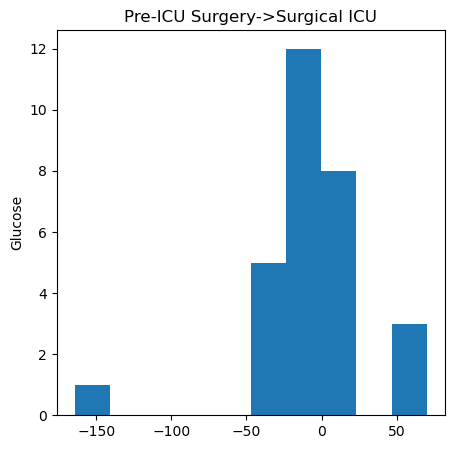

In [17]:
from package.plotting import plot_hist

plot_hist(analyzer.continuous_diff_df, 'Pre-ICU Surgery', 'Surgical ICU', 'Glucose')

## correlate values

In [20]:
analyzer.compute_correlations()

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

In [50]:
x = analyzer.correlation_df

In [58]:
x

,Act_1,Act_2,measure_1,measure_2,sample_size,scipy_corr,p,stat,method
0,Pre-ICU Cardiology,Cardiac ICU,Glucose,Glucose,88,1.000000,NaN,NaN,pearson
1,Pre-ICU Cardiology,Cardiac ICU,Glucose,Potassium,87,-0.157674,NaN,NaN,pearson
2,Pre-ICU Cardiology,Cardiac ICU,Glucose,Sodium,86,-0.028901,NaN,NaN,pearson
3,Pre-ICU Cardiology,Cardiac ICU,Glucose,Chloride,87,-0.015602,NaN,NaN,pearson
4,Pre-ICU Cardiology,Cardiac ICU,Glucose,Bicarbonate,87,0.087830,NaN,NaN,pearson
...,...,...,...,...,...,...,...,...,...
570,Surgical ICU,Post-ICU Surgery,sum_timestamp,Abnormal PT_change,108,NaN,0.644958,1.664037,kruskal
571,Surgical ICU,Post-ICU Surgery,sum_timestamp,Abnormal pO2_change,13,NaN,0.703458,2.175824,kruskal
572,Surgical ICU,Post-ICU Surgery,sum_timestamp,Abnormal Calculated Total CO2_change,13,NaN,0.263388,6.467033,kruskal
573,Surgical ICU,Post-ICU Surgery,sum_timestamp,Abnormal pCO2_change,13,NaN,0.161771,7.901099,kruskal


In [56]:
x.loc[x["method"] == "pearson"]

,Act_1,Act_2,measure_1,measure_2,sample_size,scipy_corr,p,stat,method
0,Pre-ICU Cardiology,Cardiac ICU,Glucose,Glucose,88,1.000000,NaN,NaN,pearson
1,Pre-ICU Cardiology,Cardiac ICU,Glucose,Potassium,87,-0.157674,NaN,NaN,pearson
2,Pre-ICU Cardiology,Cardiac ICU,Glucose,Sodium,86,-0.028901,NaN,NaN,pearson
3,Pre-ICU Cardiology,Cardiac ICU,Glucose,Chloride,87,-0.015602,NaN,NaN,pearson
4,Pre-ICU Cardiology,Cardiac ICU,Glucose,Bicarbonate,87,0.087830,NaN,NaN,pearson
...,...,...,...,...,...,...,...,...,...
10773,Pre-ICU Surgery,Surgical ICU,Calculated Total CO2,pCO2,10,0.697788,NaN,NaN,pearson
10774,Pre-ICU Surgery,Surgical ICU,Calculated Total CO2,RDW-SD,4,0.442313,NaN,NaN,pearson
10775,Pre-ICU Surgery,Surgical ICU,pCO2,pCO2,10,1.000000,NaN,NaN,pearson
10776,Pre-ICU Surgery,Surgical ICU,pCO2,RDW-SD,4,0.482163,NaN,NaN,pearson


In [57]:
len(x.loc[(x["method"] == "pearson") & (x["scipy_corr"] > 0.6) & (x["measure_1"] != x["measure_2"])].sort_values(["sample_size","scipy_corr"], ascending=False))

710

In [36]:
x.loc[(x["method"] == "cramer") & (x["scipy_corr"] > 0.6) & (x["measure_1"] != x["measure_2"]) & (x["sample_size"] > 100)].sort_values(["sample_size","scipy_corr"], ascending=False)

,Act_1,Act_2,measure_1,measure_2,sample_size,scipy_corr,p,stat,method
2271,Medical ICU,Post-ICU Medicine,Abnormal Hematocrit_change,Abnormal Hemoglobin_change,933,0.716545,NaN,NaN,cramer
9630,Surgical ICU,Post-ICU Medicine,Abnormal Hematocrit_change,Abnormal Hemoglobin_change,664,0.691096,NaN,NaN,cramer
2392,Medical ICU,Post-ICU Medicine,Abnormal INR(PT)_change,Abnormal PT_change,458,0.882438,NaN,NaN,cramer
4313,Post-ICU Surgery,Discharged,Abnormal Hematocrit_change,Abnormal Red Blood Cells_change,400,0.628000,NaN,NaN,cramer
3639,Post-ICU Medicine,Discharged,Abnormal INR(PT)_change,Abnormal PT_change,397,0.805536,NaN,NaN,cramer
538,Cardiac ICU,Post-ICU Cardiology,Abnormal Hematocrit_change,Abnormal Red Blood Cells_change,323,0.650763,NaN,NaN,cramer
9751,Surgical ICU,Post-ICU Medicine,Abnormal INR(PT)_change,Abnormal PT_change,290,0.860509,NaN,NaN,cramer
10014,Surgical ICU,Post-ICU Surgery,Abnormal Hematocrit_change,Abnormal Red Blood Cells_change,268,0.701636,NaN,NaN,cramer
10008,Surgical ICU,Post-ICU Surgery,Abnormal Hematocrit_change,Abnormal Hemoglobin_change,267,0.777241,NaN,NaN,cramer
10029,Surgical ICU,Post-ICU Surgery,Abnormal Hemoglobin_change,Abnormal Red Blood Cells_change,267,0.666938,NaN,NaN,cramer


In [58]:
x.loc[(x["Act_1"] == "Medical ICU") & (x["Act_2"] == "Post-ICU Medicine") & (x["measure_1"] == "Urea Nitrogen") & (x["measure_2"] == "Abnormal Creatinine_change")]

,Act_1,Act_2,measure_1,measure_2,sample_size,scipy_corr,p,stat,method
4360,Medical ICU,Post-ICU Medicine,Urea Nitrogen,Abnormal Creatinine_change,949,NaN,1.047843e-17,16.111722,anova


In [71]:
analyzer.compute_correlation_for_single_cell("Medical ICU", "Post-ICU Medicine", "Medical ICU", "Post-ICU Medicine", "Urea Nitrogen", "Creatinine", " ", " ")

(0.64347555351737, 1, 0, 949, 'pearson')

In [88]:
y = analyzer.compute_correlation_of_one_with_all_cells("Medical ICU", "Post-ICU Medicine", "Creatinine", "")

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

In [90]:
y.loc[y["sample_size"] > 100]

,Act_1,Act_2,Act_3,Act_4,measure_1,measure_2,sample_size,scipy_corr,p,stat,method
0,Medical ICU,Post-ICU Medicine,Emergency Department,Medical ICU,Creatinine,sum_timestamp,833,-0.051308,1.000000,0.000000,spearman
5,Medical ICU,Post-ICU Medicine,Post-ICU Medicine,Discharged,Creatinine,Glucose,795,0.028473,1.000000,0.000000,pearson
6,Medical ICU,Post-ICU Medicine,Post-ICU Medicine,Discharged,Creatinine,Potassium,806,0.034400,1.000000,0.000000,pearson
7,Medical ICU,Post-ICU Medicine,Post-ICU Medicine,Discharged,Creatinine,Sodium,803,0.102597,1.000000,0.000000,pearson
8,Medical ICU,Post-ICU Medicine,Post-ICU Medicine,Discharged,Creatinine,Chloride,802,0.040053,1.000000,0.000000,pearson
9,Medical ICU,Post-ICU Medicine,Post-ICU Medicine,Discharged,Creatinine,Bicarbonate,793,0.008207,1.000000,0.000000,pearson
10,Medical ICU,Post-ICU Medicine,Post-ICU Medicine,Discharged,Creatinine,Creatinine,799,0.198334,1.000000,0.000000,pearson
11,Medical ICU,Post-ICU Medicine,Post-ICU Medicine,Discharged,Creatinine,Anion Gap,793,0.072108,1.000000,0.000000,pearson
12,Medical ICU,Post-ICU Medicine,Post-ICU Medicine,Discharged,Creatinine,Urea Nitrogen,796,0.268619,1.000000,0.000000,pearson
13,Medical ICU,Post-ICU Medicine,Post-ICU Medicine,Discharged,Creatinine,Magnesium,691,0.056659,1.000000,0.000000,pearson


In [52]:
rel = ("Medical ICU", "Post-ICU Medicine")

In [55]:
rel[1]

'Post-ICU Medicine'

In [91]:
analyzer.compute_correlation_of_one_with_all_cells("Medical ICU", "Post-ICU Medicine", "Creatinine", "")

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable values is less than 2. Cannot calculate correlation
Intersection of usable va

,Act_1,Act_2,Act_3,Act_4,measure_1,measure_2,sample_size,scipy_corr,p,stat,method
0,Medical ICU,Post-ICU Medicine,Emergency Department,Medical ICU,Creatinine,sum_timestamp,833,-0.051308,1.000000e+00,0.000000,spearman
1,Medical ICU,Post-ICU Medicine,Emergency Department,Pre-ICU Cardiology,Creatinine,sum_timestamp,7,0.111555,1.000000e+00,0.000000,pearson
2,Medical ICU,Post-ICU Medicine,Emergency Department,Pre-ICU Medicine,Creatinine,sum_timestamp,90,0.080292,1.000000e+00,0.000000,spearman
3,Medical ICU,Post-ICU Medicine,Emergency Department,Pre-ICU Surgery,Creatinine,sum_timestamp,19,-0.384379,1.000000e+00,0.000000,spearman
4,Medical ICU,Post-ICU Medicine,Post-ICU Cardiology,Discharged,Creatinine,sum_timestamp,3,1.000000,1.000000e+00,0.000000,spearman
5,Medical ICU,Post-ICU Medicine,Post-ICU Medicine,Discharged,Creatinine,Glucose,795,0.028473,1.000000e+00,0.000000,pearson
6,Medical ICU,Post-ICU Medicine,Post-ICU Medicine,Discharged,Creatinine,Potassium,806,0.034400,1.000000e+00,0.000000,pearson
7,Medical ICU,Post-ICU Medicine,Post-ICU Medicine,Discharged,Creatinine,Sodium,803,0.102597,1.000000e+00,0.000000,pearson
8,Medical ICU,Post-ICU Medicine,Post-ICU Medicine,Discharged,Creatinine,Chloride,802,0.040053,1.000000e+00,0.000000,pearson
9,Medical ICU,Post-ICU Medicine,Post-ICU Medicine,Discharged,Creatinine,Bicarbonate,793,0.008207,1.000000e+00,0.000000,pearson


### Plotting information for one correlation result

In [29]:
analyzer.continuous_correlation_df[analyzer.continuous_correlation_df['sample_size'] > 100].sort_values('scipy_corr')

AttributeError: 'ProcessChangeAnalyzer' object has no attribute 'continuous_correlation_df'

###  investigate correlations

In [ ]:
analyzer.filter_strong_correlations()

In [ ]:
analyzer.show_correlation_frequency_by_measurement_pair(analyzer.continuous_correlation_df)

In [ ]:
analyzer.show_correlation_frequency_by_measurement_pair(analyzer.cramer_df)

## Process characteristic correlation

In [ ]:
analyzer.get_process_characteristics_correlation()

In [ ]:
analyzer.show_correlation_frequency_by_measurement_pair(analyzer.get_process_characteristics_correlation())

In [ ]:
# pick one row and show plots
analyzer.visualize_row('Post-ICU Medicine', 'Discharged', 'MCHC','MCV')

## categorical correlation detection

In [ ]:
analyzer.get_contingency_table('Surgical ICU', 'Post-ICU Surgery', 'Abnormal Urea Nitrogen_change', 'Abnormal pH_change')

## Clustering

In [ ]:
clustering_attributes = ['Hemoglobin', 'Hematocrit', 'Red Blood Cells']

clusters = analyzer.cluster(clustering_attributes, 3)
clusters

In [ ]:
cluster_0 = clusters[clusters['cluster'] == 0]
cluster_0

In [ ]:
cluster_1 = clusters[clusters['cluster'] == 1]
cluster_1

In [ ]:
cluster_2 = clusters[clusters['cluster'] == 2]
cluster_2

## process model enhancement

In [ ]:
analyzer.visualize(['Hemoglobin', 'Hematocrit', 'Red Blood Cells'])

### Visualization correlation of Hemoglobin, Red Blood Cells and Hematocrit

In [ ]:
interesting_measures = ['Hemoglobin', 'Hematocrit', 'Red Blood Cells']
interesting_df = analyzer.filter_correlation_by_measurements(interesting_measures)

In [ ]:
interesting_df

In [ ]:
# plotting correlation 
def plot_correlation_single(row, axs):
    try:
        axs.set_title(f"{row['measure_1']} -> {row['measure_2']}, {row['scipy_corr']}")
        axs.set_xlabel(f"{row['Act_1']} -> {row['Act_2']}.: #samples: {row['sample_size']}, {row['method']}")
        axs.scatter(row['values_1'], row['values_2'])
    except Exception as e:
        print(e)

In [ ]:
def show_values(df):
    fig_per_row = 4
    fig_per_column = int(np.ceil(len(df) / fig_per_row))
    
    fig, axs = plt.subplots(fig_per_column , fig_per_row, figsize=(7*fig_per_row,fig_per_column * 7))
    for i in range(len(df)):
        plot_correlation_single(df.iloc[i], axs[int(i/4), i%4])
    plt.show()

In [ ]:
show_values(interesting_df)